In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [11]:
df = pd.read_excel('champagne-sales.xlsx')
df.head(3)

,Month,Champagne Sales
0,1-01,2851
1,1-02,2672
2,1-03,2755


In [12]:
df['period'] = df.Month.apply(lambda x: x.split('-')[0])
df['month'] = df.Month.apply(lambda x: x.split('-')[1]).astype(str)
df['year'] = (df.period.astype(int) + 2000).astype(str)
df['date'] = df.year + '-' + df.month
df.date = pd.to_datetime(df.date)
df.set_index(df.date, inplace=True)
df.rename(columns={'Champagne Sales':'sales'}, inplace=True)
df.drop(columns=['Month','period','month','year', 'date'], inplace=True)
df.head(2)

,sales
date,
2001-01-01,2851
2001-02-01,2672


### Classical Decomposition (naive)

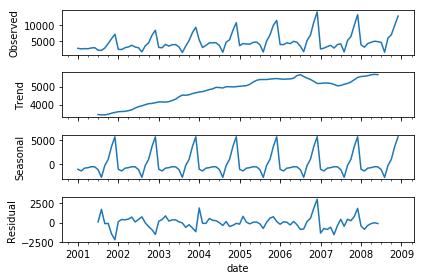

In [13]:
result = sm.tsa.seasonal_decompose(df)
result.plot();

# Model Training
Now that we have decomposed the Time Series, it will provide valuable insight into the most likely appropriate parameters to use with time series forecasting models.
Let's compare the performance of two of the most typical approaches: 1) ETS (AKA Holt-Winters); and 2) ARIMA (and its seasonal variations, SARIMAX).

## Pre-processing
Adjust the dataframe to work with `statsmodels` implementations, as well as setting the appropriate index as data-time, set target feature as double datatype (required by `statsmodels`), and split training/validation dataset:

In [14]:
# Check index is set as datetime data type
assert type(df.index) == pd.core.indexes.datetimes.DatetimeIndex

In [15]:
df.sales = df.sales.astype('double')

In [16]:
# Split Train/Validation. Last 6 months as validation

df_train = df.loc[df.index[:-6]]
df_test = df.loc[df.index[-6:]]

## 1) ETS (Holt-Winters)

In [17]:
try:
    v = sm.version.version
except:
    v = sm.__version__
print(f'Statsmodels version has to be >= 0.10 | Current version is {v}')

# ! pip install statsmodels --upgrade

# Requires to restart kernel after installation

Statsmodels version has to be >= 0.10 | Current version is 0.10.0


In [18]:
# Necessary to use latest version of statsmodels (>= 0.10), otherwise throws error. 
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS

model = ETS(df_train, trend=None, damped=False, seasonal_periods=12, seasonal='mul')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
forecast = model.fit()

In [20]:
yhat = forecast.forecast(6)

2008-07-01     4074.576914
2008-08-01     2153.467925
2008-09-01     5172.220501
2008-10-01     6798.234148
2008-11-01    10175.086213
2008-12-01    12746.642866
Freq: MS, dtype: float64


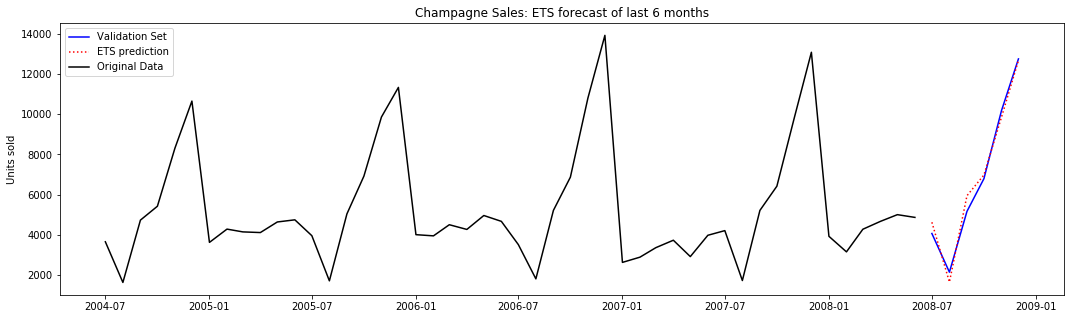

In [21]:
plt.figure(figsize=(18,5))
plt.plot(yhat, ls='-', c='b', label='Validation Set')
plt.plot(df_test, ls=':', c='r', label='ETS prediction')
plt.plot(df_train[-48:], ls='-', c='k', label='Original Data')
plt.title('Champagne Sales: ETS forecast of last 6 months')
plt.legend()
plt.ylabel('Units sold');
print(yhat)

In [30]:
score_ETS = forecast.aic
print(f'ETS model AIC: {score_ETS:,.2f}')

ETS model AIC: 1,164.26


In [22]:
forecast.summary()

Dep. Variable:,endog,No. Observations:,90
Model:,ExponentialSmoothing,SSE,27368860.251
Optimized:,True,AIC,1164.260
Trend:,None,BIC,1199.257
Seasonal:,Multiplicative,AICC,1171.712
Seasonal Periods:,12,Date:,"Thu, 11 Jul 2019"
Box-Cox:,False,Time:,09:39:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4558209,alpha,True
smoothing_seasonal,0.000000,gamma,True


## 3) Prophet (Facebook) - TO BE SKIPPED until fix Time Series decompose plot
Some extra steps are required to get this amazing package to work. 
1. Install pystan
2. Install fbprophet

These have been added in the `requirements` file and should be auto-installed when setting up the environment.

In [ ]:
# ! pip install pystan

In [ ]:
# ! pip install fbprophet

This package requires the dataframe to be structured in a very particular manner, having columns (not the datetime index) as:
+ Date component named as "ds"
+ Feature of interest named as "y"

In [43]:
# Create a copy to prepare column names as required
df2 = df.copy()

In [44]:
# remove date as index
df2.reset_index(inplace=True)

# rename columns as required
df2.rename(columns={'date':'ds', 'sales':'y'}, inplace=True)

df2.head(2)

,ds,y
0,2001-01-01,2851.0
1,2001-02-01,2672.0


In [45]:
# Split training and validation data
df2_train = df2.loc[df2.index[:-6]]
df2_test = df2.loc[df2.index[-6:]]

In [46]:
from fbprophet import Prophet
model = Prophet()
model.fit(df2_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
# Create date time data to be forecasted
future_data = model.make_future_dataframe(6, freq='m')

In [48]:
# Actually perform forecasting with the trained model
forecast_data = model.predict(future_data)

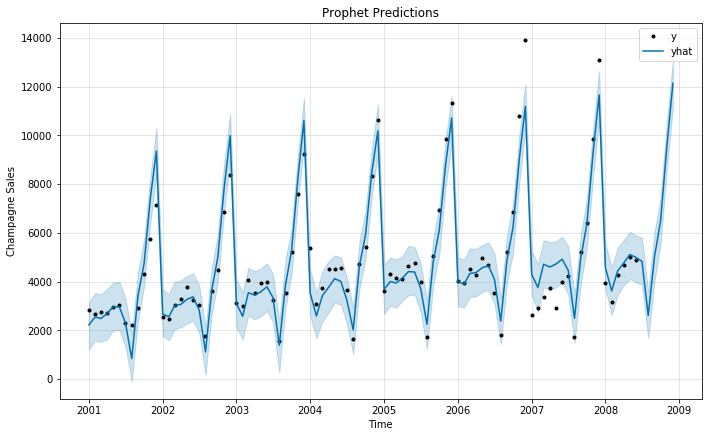

In [52]:
# Plot predictions vs actual values
model.plot(forecast_data);
plt.legend()
plt.title('Prophet Predictions')
plt.ylabel('Champagne Sales')
plt.xlabel('Time');

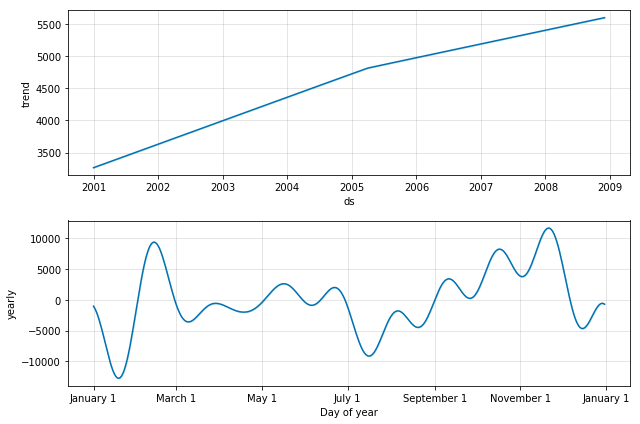

In [55]:
# Plot influence of Time Series components
model.plot_components(forecast_data);

Since we are working with Monthly data, the components plot display the influence of overall Trend and Yearly seasonality.
+ Trend: has a vast influence in the data distribution. Is continuing growing, although not as much as during the yearly years.
+ Seasonality: has a positive impact during midFebruary and mid-October through early-December, with significant valleys in January and July.

This is interesting, as one could expect higher amount of Champagne sales close to New Year's events. But it seems people are actually purchasing them with at least one month in advance! This could be explained if the sales data comes from the actual producer/distributor and not the client facing retail.